In [1]:
# a hack to import module from different directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem

import utils as utils
from signal_generator import SignalGenerator
from baseline_receiver import BaselineReceiver
from modular_receiver import ModularReceiver

# Visualization
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()  # Use seaborn as backend of matplotlib for vis

## Define Paramters for the comparison

In [3]:
# For encoding/decoding convolutional codes
G = np.array([[0o7, 0o5]]) 
M = np.array([2])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

class Params:
    SNR_RANGE = range(-5, 30, 5)
    NUM_SAMPLES = 1000
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
modem = QAMModem(m=Params.QAM16)
signal_generator = SignalGenerator(modem=modem)

## Define Baseline (Demod + Viterbi) & Modular Receivers (NN + RNN)

In [4]:
baseline_receiver = BaselineReceiver(modem, trellis)
modular_receiver  = ModularReceiver(demod_model_path='../models/demod_model_qam16.hdf5',
                                    decoder_model_path='../models/bigru4.hdf5')

## Evaluate Baseline  on multiple SNRs

* For each SNR, generate (orignal message bits, modulated signals, noisy signals) using `SignalGenerator`.
* Run demodulation of baseline and modular version (a NN).
* Run decoder of baseline (viterbi) and modular version (a RNN).
* Log and results and plot

 14%|█▍        | 1/7 [00:36<03:36, 36.09s/it]

SNR=-5.000000
	[Baseline] Acc = 0.17 | Ber = 0.36 
	[Modular]  Acc = 0.17 | Ber = 0.38


 29%|██▊       | 2/7 [01:11<02:58, 35.64s/it]

SNR=0.000000
	[Baseline] Acc = 0.27 | Ber = 0.27 
	[Modular]  Acc = 0.27 | Ber = 0.31


 43%|████▎     | 3/7 [01:46<02:21, 35.38s/it]

SNR=5.000000
	[Baseline] Acc = 0.47 | Ber = 0.18 
	[Modular]  Acc = 0.47 | Ber = 0.24


 57%|█████▋    | 4/7 [02:24<01:48, 36.05s/it]

SNR=10.000000
	[Baseline] Acc = 0.78 | Ber = 0.06 
	[Modular]  Acc = 0.78 | Ber = 0.15


 71%|███████▏  | 5/7 [02:59<01:11, 35.96s/it]

SNR=15.000000
	[Baseline] Acc = 0.98 | Ber = 0.01 
	[Modular]  Acc = 0.98 | Ber = 0.06


 86%|████████▌ | 6/7 [03:36<00:36, 36.08s/it]

SNR=20.000000
	[Baseline] Acc = 1.00 | Ber = 0.00 
	[Modular]  Acc = 1.00 | Ber = 0.04


100%|██████████| 7/7 [04:13<00:00, 36.15s/it]

SNR=25.000000
	[Baseline] Acc = 1.00 | Ber = 0.00 
	[Modular]  Acc = 1.00 | Ber = 0.04


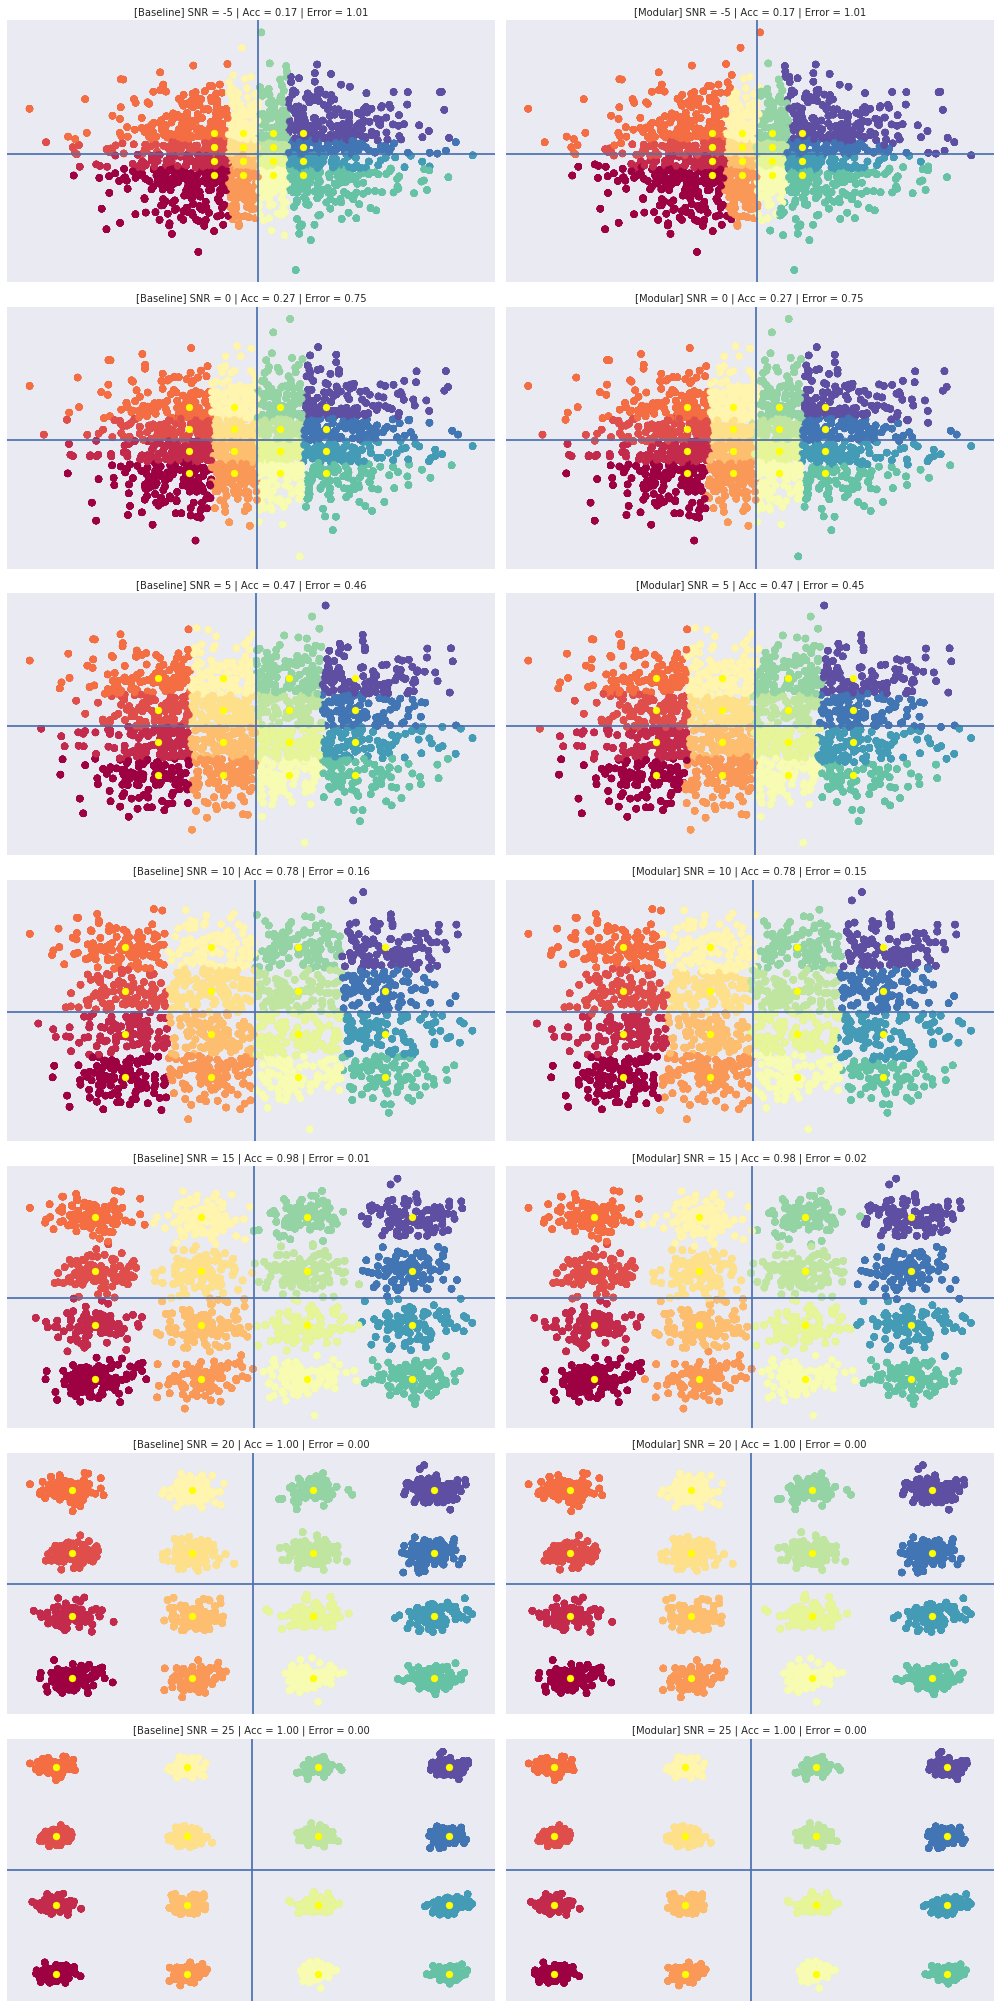

In [5]:
import tqdm

errors_logs = []
accuracies_logs = []
ber_logs  = []
bler_logs = []

fig, axes = plt.subplots(len(Params.SNR_RANGE), 2, figsize=(14, 4 * len(Params.SNR_RANGE)))
for i, snr in tqdm.tqdm(enumerate(Params.SNR_RANGE), total=len(Params.SNR_RANGE)):
    (original_bits, clean_signals, noisy_signals) = signal_generator(
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr_in_dB=snr)
    
    complex_inputs = noisy_signals.flatten()
    mapping, ground_truths = np.unique(clean_signals.flatten(), return_inverse=True)

    # ####################################
    # Run Baseline/Neral Demodulation
    # ####################################
    baseline_predictions = baseline_receiver.demodulate(complex_inputs)
    baseline_demoded     = modem.demodulate(mapping[baseline_predictions].flatten(), 'hard')
    baseline_estimated   = baseline_receiver.decode(baseline_demoded) # Viterbi
    
    nn_predictions       = modular_receiver.demodulate(complex_inputs)

    # ####################################
    # Run Baseline/Neral Decoder
    # ####################################
    
    # Convert Symbols to Complex Number, then to real numbers.
    baseline_demoded = modem.demodulate(mapping[baseline_predictions].flatten(), 'hard')
    nn_demoded       = modem.demodulate(mapping[nn_predictions].flatten(), 'hard')
    
    # Preprocess input to feed into RNN
    nn_demoded = nn_demoded.reshape((Params.NUM_SAMPLES, -1))
    nn_demoded = nn_demoded[:, : 2 * Params.BLOCK_LENGTH].reshape((-1, Params.BLOCK_LENGTH, 2))
    
    # Estimate original bits using baseline (viterbi) and nn decoder
    baseline_estimated = baseline_receiver.decode(baseline_demoded) # Viterbi
    nn_estimated       = modular_receiver.decode(nn_demoded)        # Bi-directional GRU
    
    nn_estimated = np.where(nn_estimated > 0.5, 1, 0).astype(np.int)
    baseline_estimated = baseline_estimated.reshape((Params.NUM_SAMPLES, -1))[:, :Params.BLOCK_LENGTH]
    
    # ####################################
    # Measure Accuracy / error
    # #################################### 
    # For demod
    acc, err       = utils.get_scores(baseline_predictions, ground_truths)    
    nn_acc, nn_err = utils.get_scores(nn_predictions, ground_truths)
    
    # For decoder
    ber, bler        = utils.get_ber_bler(baseline_estimated, original_bits)
    nn_ber, nn_bler = utils.get_ber_bler(nn_estimated, original_bits)
    
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    errors_logs.append([err, nn_err])
    accuracies_logs.append([acc, nn_acc])
    
    # ####################################
    # Visualize Modulation
    # ####################################
    data_point_limit = 10000
    title    = '[Baseline] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, acc, err)
    nn_title = '[Modular] SNR = {} | Acc = {:.2f} | Error = {:.2f}'.format(snr, nn_acc, nn_err)
    
    print('SNR=%f' % snr)
    print('\t[Baseline] Acc = {:.2f} | Ber = {:.4f} '.format(acc, ber))
    print('\t[Modular]  Acc = {:.2f} | Ber = {:.4f}'.format(nn_acc, nn_ber))
    
    utils.visualize_demodulation(complex_inputs[:data_point_limit], modem.constellation, ax=axes[i, 0],
        predictions=baseline_predictions[:data_point_limit],
        title=title)

    utils.visualize_demodulation(complex_inputs[:data_point_limit], modem.constellation, ax=axes[i, 1],
        predictions=nn_predictions[:data_point_limit],
        title=nn_title)

fig.tight_layout()

### Compare Demodulation Performance (Error / Accuracy)

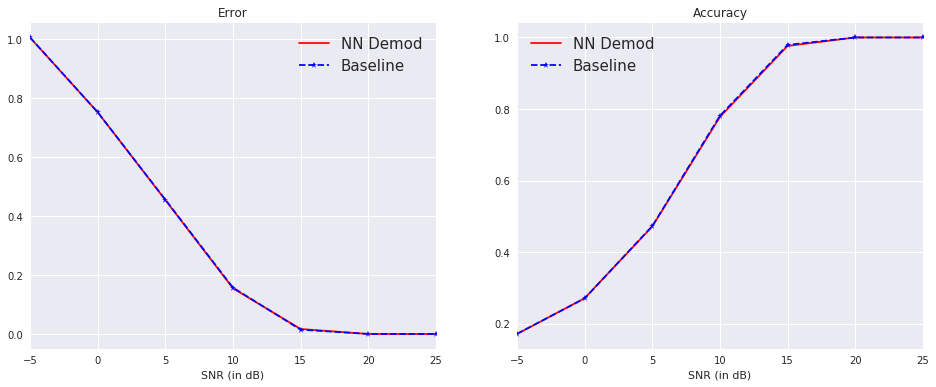

In [6]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_acc_err(ax1, ax2, errors_logs, accuracies_logs, Params.SNR_RANGE)

### Compare Decoder Performance (error / accuracy)

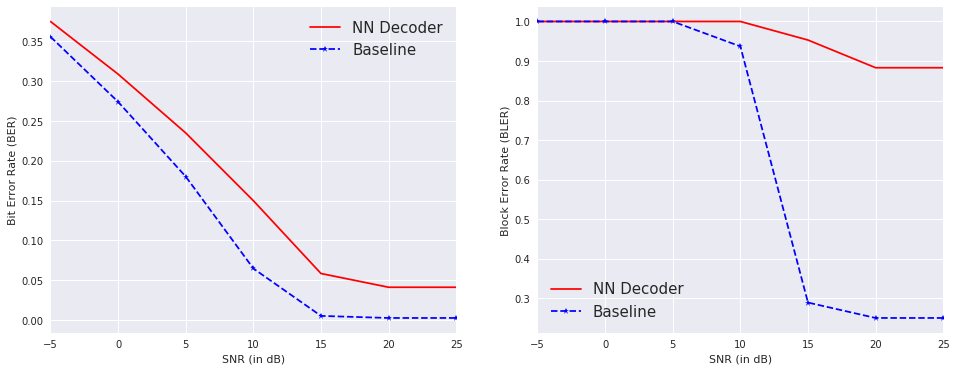

In [7]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)